### Loading the CLIP model

In [1]:
# I have chosen to use the same OpenCLIP model as used in week 8

import open_clip
import numpy as np
import torch
from PIL import Image
import os
import csv
import matplotlib.pyplot as plt

model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

/Users/v/miniconda3/envs/aim2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# most of this code has been created by prompting ChatGPT and then editing and restructuring it for the needs of the project

### Selecting the input image and the language of film recommendations

The input image is the image that will be matched to film posters in the dataset

In [3]:
# Input image file path - Select the input image
input_image_path = "input_images/John_Singer_Sargent_-_Carnation,_Lily,_Lily,_Rose_-_Google_Art_Project.jpg"

# Choose the language for film recommendations - 'french', 'english', or 'hindi'
language = "english"

# Select the number of film recommendations
number = 5

### Encoding the input image and saving the encoded features

Run the below cell again only if the input image is changed.

In [4]:
# function to encode an image
def encode_image(image_path):
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features.cpu().numpy()

# encoding the input image
input_image_features = encode_image(input_image_path)

# saving the encoded features to a file
np.save('input_encoded_features.npy', input_image_features)

### Semantically matching the input image to the film posters
The 3 closest matches are selected as film recommendations.

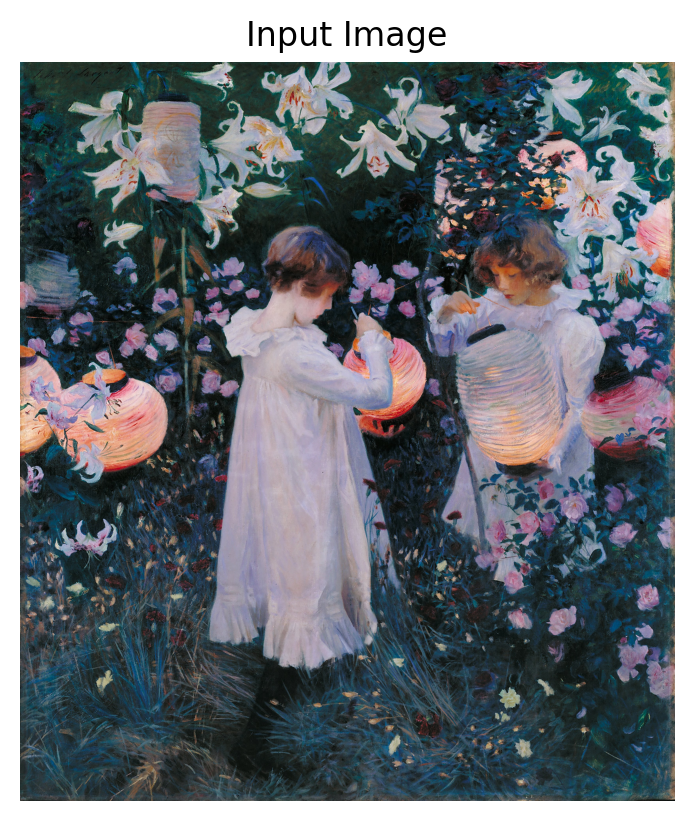

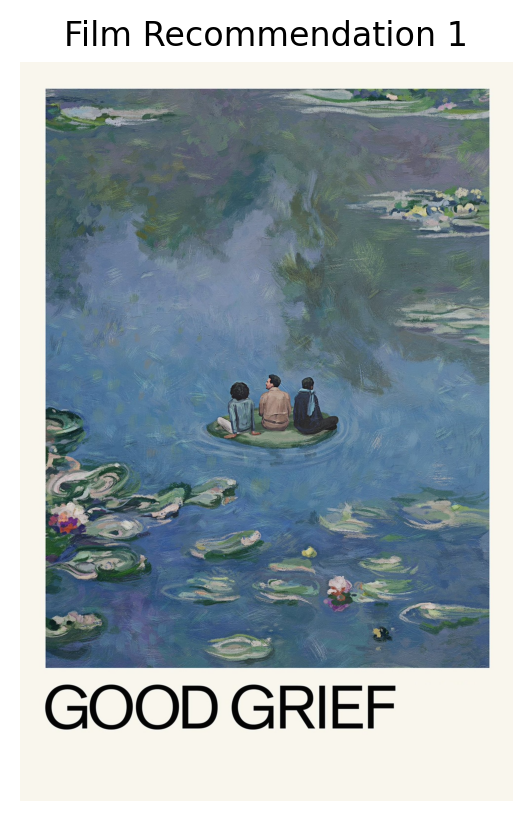

title: Good Grief
original_title: Good Grief
release_date: 2023-12-19
rating: 6.5
overview: When his husband unexpectedly dies, Marc's world shatters, sending him and his two best friends on a soul-searching trip to Paris that reveals some hard truths they each needed to face.


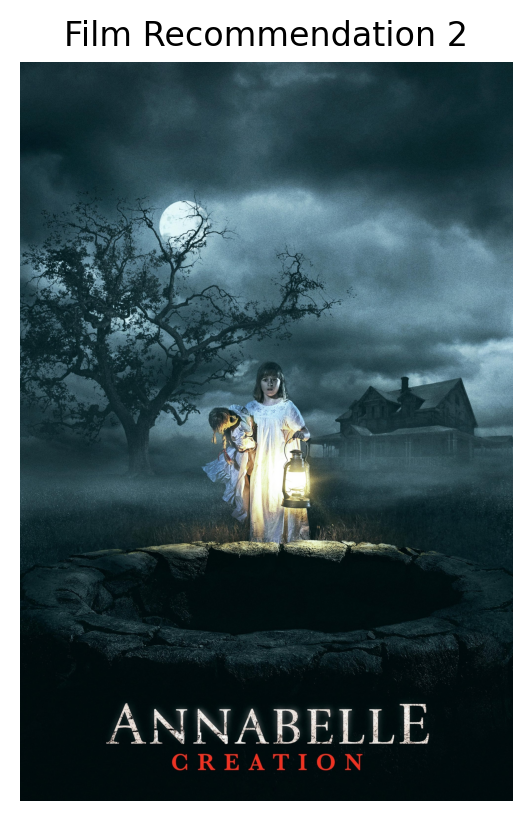

title: Annabelle: Creation
original_title: Annabelle: Creation
release_date: 2017-08-03
rating: 6.597
overview: Several years after the tragic death of their little girl, a doll maker and his wife welcome a nun and several girls from a shuttered orphanage into their home, soon becoming the target of the doll maker's possessed creation—Annabelle.


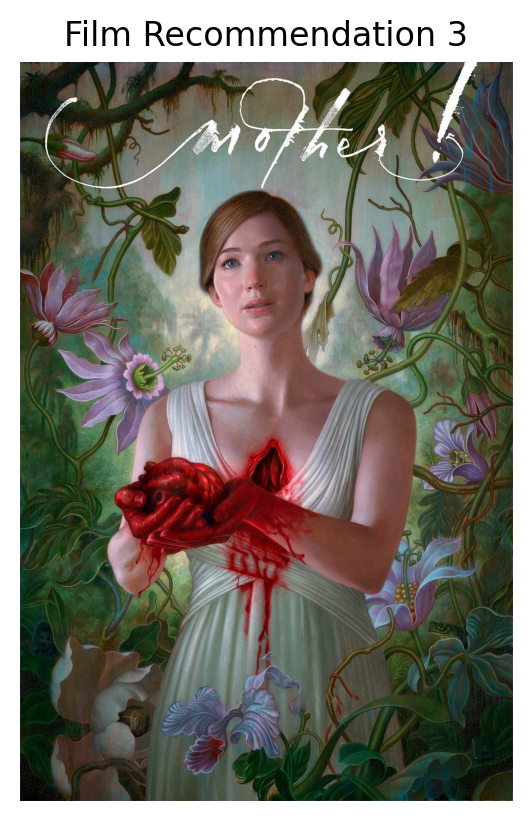

title: mother!
original_title: mother!
release_date: 2017-09-13
rating: 6.971
overview: A couple's relationship is tested when uninvited guests arrive at their home, disrupting their tranquil existence.


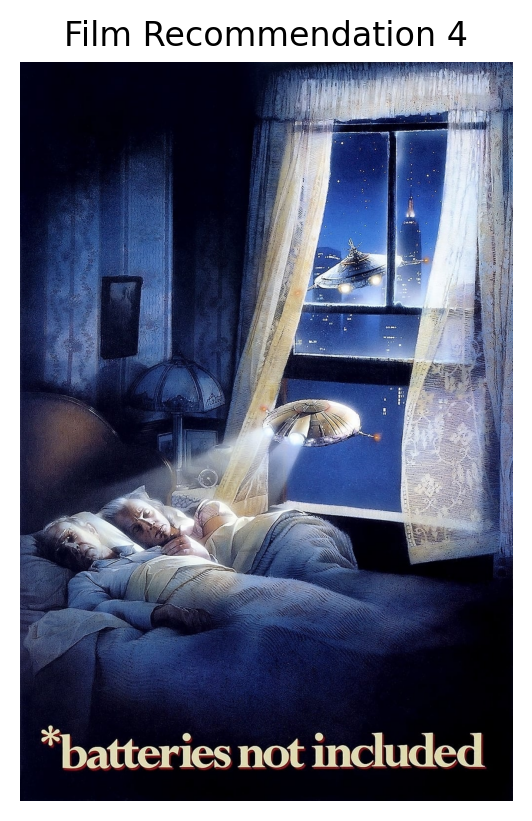

title: *batteries not included
original_title: *batteries not included
release_date: 1987-12-18
rating: 6.7
overview: In a soon to be demolished block of apartments, the residents resist the criminal methods used to force them to leave so a greedy tycoon can build his new skyscraper. When tiny mechanical aliens land for a recharge, they decide to stay and help out.


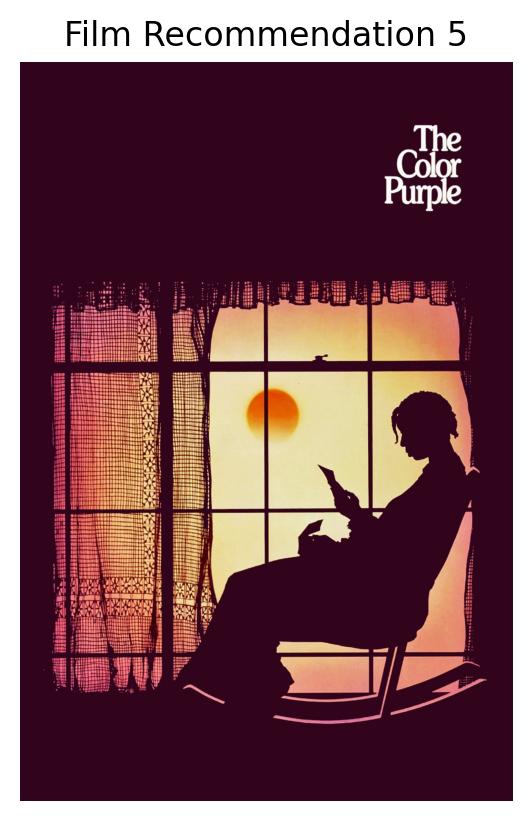

title: The Color Purple
original_title: The Color Purple
release_date: 1985-12-18
rating: 7.752
overview: An epic tale spanning forty years in the life of Celie, an African-American woman living in the South who survives incredible abuse and bigotry. After Celie's abusive father marries her off to the equally debasing 'Mister' Albert Johnson, things go from bad to worse, leaving Celie to find companionship anywhere she can. She perseveres, holding on to her dream of one day being reunited with her sister in Africa.


In [5]:
# setting a high resolution display
%config InlineBackend.figure_format = 'retina'

# global variables
folder_path = ""
csv_file_path = ""
encoded_features = ""

# function to load encoded features based on choice of language
def load_encoded_features(language):
    global folder_path, csv_file_path, encoded_features
    if language.lower() == "french":
        folder_path = "movie_posters_french_10k"
        csv_file_path = "movie_data_french_10k.csv"
        encoded_features = "french_poster_features.npy"
    elif language.lower() == "english":
        folder_path = "movie_posters_10k"
        csv_file_path = "movie_data_10k.csv"
        encoded_features = "poster_features.npy"
    elif language.lower() == "hindi":
        folder_path = "movie_posters_hindi_7k"
        csv_file_path = "movie_data_hindi_7k.csv"
        encoded_features = "hindi_poster_features.npy"
    else:
        print("Invalid language input. Defaulting to English.")
        folder_path = "movie_posters_10k"
        csv_file_path = "movie_data_10k.csv"
        encoded_features = "poster_features.npy"

# loading encoded features based on choice of language
load_encoded_features(language)

# loading the encoded features of the input image
input_image_features = np.load('input_encoded_features.npy')

# getting the list of image files in the specified folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# loading the pre-encoded poster features
poster_features = np.load(encoded_features, allow_pickle=True)

# computing similarity scores
similarities = np.dot(input_image_features, np.array(poster_features).reshape(len(poster_features), -1).T)

# finding the indices of the top 3 images with the highest similarity scores
top_indices = np.argsort(similarities[0])[-number:][::-1]

# displaying the input image
input_image = Image.open(input_image_path)
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')
plt.show()

# displaying the closest matches
for i, idx in enumerate(top_indices, start=1):
    matched_image_path = image_files[idx]
    matched_image = Image.open(matched_image_path)
    plt.imshow(matched_image)
    plt.title(f'Film Recommendation {i}')
    plt.axis('off')
    plt.show()

    # extracting the image filename without extension
    matched_image_name = os.path.splitext(os.path.basename(matched_image_path))[0]

    # converting the image filename to an integer
    matched_image_id = int(matched_image_name)

    # matching the filename (film id) to the film details in the CSV file
    with open(csv_file_path, 'r', newline='', encoding='utf-8') as csv_file:
        reader = csv.DictReader(csv_file)
        headers = reader.fieldnames
        if 'id' not in headers:
            print("Error: 'id' column not found in the CSV file.")
        else:
            for row in reader:
                if int(row['id']) == matched_image_id:

                    # printing film details 
                    print(f"title: {row['title']}")
                    print(f"original_title: {row['original_title']}")
                    print(f"release_date: {row['release_date']}")
                    print(f"rating: {row['vote_average']}")
                    print(f"overview: {row['overview']}")
                    break
